(sec:intro)=
# 1. Uvod v procesiranje signalov

Uvodno poglavje predstavi motivacijo za knjigo, definira nekatere termine in predstavi strukturo knjige.

Poglavja v knjigi so:

- {ref}`sec:fourierove_vrste`,
- {ref}`sec:fourierova_int_transf`,
- {ref}`sec:LTI`,
- {ref}`sec:kvantizacija_podatkov`,
- {ref}`sec:DFT`,
- {ref}`sec:random`,
- {ref}`sec:LTI-random`.

(sec:kaj_je_ps)=
## Kaj je procesiranje signalov?
Termin **procesiranje signalov** uporabljamo za označitev različnih metod obdelave izmerjenih podatkov z namenom, da razkrijemo informacije obravnavanega sistema. Potencialno bi lahko govorili tudi o **obdelavi podatkov**, vendar je takšen termin po eni strani preširok, po drugi strani pa preozek. Preširok bi bi zato, ker se s procesiranjem signalov želimo omejiti na identifikacijo/karakterizacijo različnih inženirskih sistemov in ne splošne obdelave poljubnih podatkov. Termin obdelava podatkov pa je preozek, saj so podatki vedno diskretni, procesiranje pa se lahko začne že na signalih, ki so lahko zvezni ali diskretni. 

Kot primer procesiranja signalov lahko izpostavimo identifikacijo *napak na ležajih* ali identifikacijo *dinamskih lastnosti struktur* (npr. dušenje, togost), v obeh primerih moramo merjene signale pravilno obdelati že preden jih časovno vzorčimo in nato kvantiziramo (glejte: {ref}`sec:kvantizacija_podatkov`). Slika spodaj prikazuje meritev sile na dobrem in dveh poškodovanih ležajih ({cite:t}`slavic2011typical`). V meritvah vidimo določene razlike, ampak ali lahko iz meritev identificiramo **tip** poškodbe? Nadalje ali lahko iz meritev identificiramo **velikost** poškodbe? Na ta in podobna vprašanja bomo poskušali odgovoriti tekom te knjige.

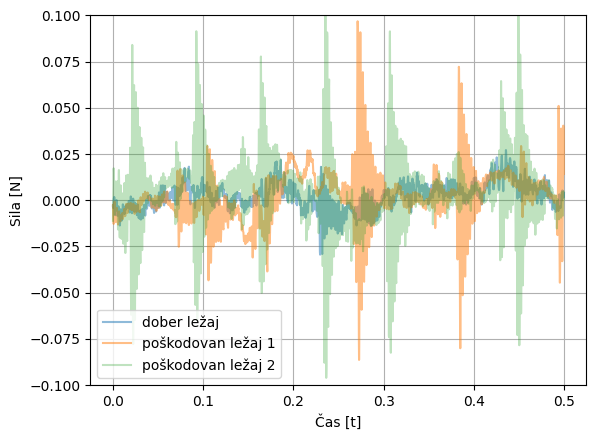

In [2]:
import numpy as np
import matplotlib.pyplot as plt

new = np.load('./data/bearing/new 1A.npy')
radial = np.load('./data/bearing/radial Low 1A.npy')
contamination = np.load('./data/bearing/contam low 2A.npy')
time = np.arange(len(new)) * 1./5000

sel = time<0.5
plt.plot(time[sel], new[sel, 2], alpha=0.5, label='dober ležaj')
plt.plot(time[sel], radial[sel, 2], alpha=0.5, label='poškodovan ležaj 1')
plt.plot(time[sel], contamination[sel, 2], alpha=0.3, label='poškodovan ležaj 2')
plt.xlabel('Čas [t]')
plt.ylabel('Sila [N]')
plt.ylim(-0.1, 0.1)
plt.grid()
plt.legend()
plt.show()

Kot naslednji primer, je spodaj prikazana **frekvenčne prenosne funkcije** (*ang.* FRF, Frequency Response Function), ki v frekvenčni domeni povezuje vzbujanje sistema z njegovim odzivom (primer je vzet iz paketa [pyUFF](https://github.com/ladisk/pyuff)). Pravilna identifikacija frekvenčne prenosne funkcije je ključna za pravilno karakterizacijo dinamskih sistemov in zato tudi eden od ključnih učnih ciljev te knjige. 


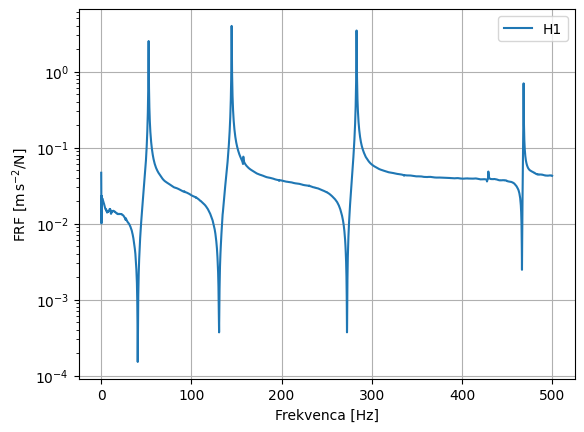

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pyuff

uff = pyuff.UFF('./data/uff/beam.uff').read_sets(setn=4)
fr = uff['x']
H1 = uff['data']

sel = fr<500
plt.semilogy(fr[sel], np.abs(H1[sel]), label='H1')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('FRF [m$\\,$s$^{-2}$/N]')
plt.grid()
plt.legend()
plt.show()

(sec:kaj_je_sistem)=
## Kaj je sistem?

Dinamske in druge sisteme ponavadi poskušamo opisati na podlagi modelov; parametre modelov pa identificirati s ekperimentalnih meritev, katere ustrezno obdelamo. Spodnja slika prikazuje poljuben sistem, katerega vzbujanje opišemo v času s $x(t)$, odziv pa s $y(t)$. Kot primer vzbujanja $x(t)$ sistema si lahko predstavljamo **silo**, ki deluje na neko **maso**, kot odziv $y(t)$ pa napetost na zaznavalu **pospeška** ali zvočnega tlaka. Odziv je pogosto merjen prek električne napetosti, katera je ponavadi proporcionalna merjeni veličini (npr.: pospešek, zvočni tlak); seveda pa je tako vzbujanje, kot odziv lahko povezan tudi z drugimi veličinami, ki jih lahko merimo npr. tokom ali z intenziteto slikovnega elementa v sliki (glejte {cite:t}`gorjup2021still`). 

![sistem-in-out](./images/sistem-in-out.svg)

Sistem, bolj natančno linearni, časovno invariantni sistem, bomo podrobno definirali v poglavju {ref}`sec:LTI`.

*Primer*: kot primer si tukaj pogledamo odziv dinamskega sistema z eno prostostno stopnjo na polsinusno motnjo s šumom. Impulzna prenosna funkcija sistema z eno prostostno stopnjo je definirana:

$$
h(t)=\frac{1}{\omega_{0d}}\,\mathrm{e}^{-\delta\,\omega_0\,t}\,\sin(\omega_{0d}\,t)
$$

Konkretno implementacijo in rezultat prikazuje koda spodaj.

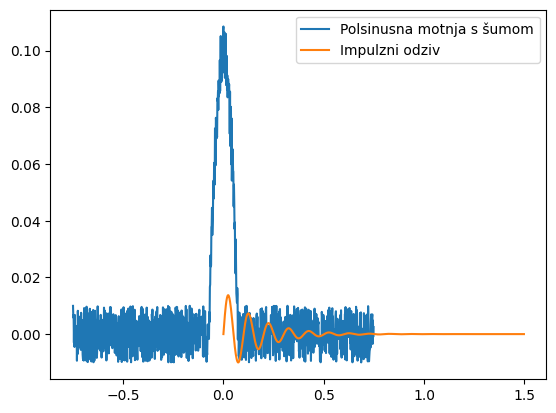

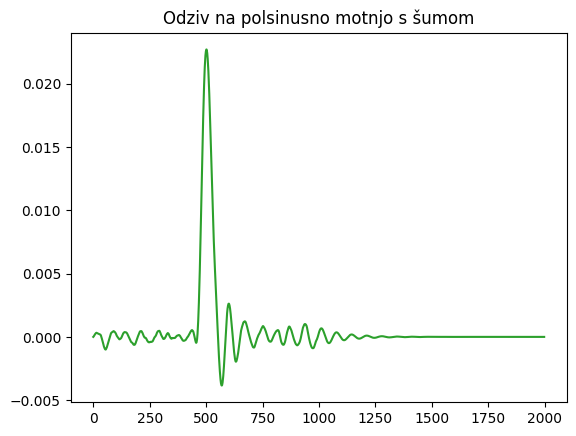

In [4]:
import numpy as np
import matplotlib.pyplot as plt

T = 1.5
N = 1000
w = 0.1
A = 0.1
t = np.linspace(-T/2, T/2, N, endpoint=False)
dt = t[1] - t[0]
x = A*np.cos(2*np.pi*t/(2*w*T))
x[np.logical_or(-w*T*0.5>t, t>w*T*0.5)] = 0.
x = x + 0.2*A*(np.random.rand(N)-0.5)

delta = 0.1 # damping ratio
omega0 = 2*np.pi*10
omega0d = omega0*np.sqrt(1-delta*delta)
th = dt*np.arange(len(x))
h = np.exp(-delta*omega0*th)*np.sin(omega0d*th)/omega0d

plt.plot(t,x, label='Polsinusna motnja s šumom')
plt.plot(th,h, label='Impulzni odziv')
plt.legend()
plt.show()

hx = np.convolve(h, x) # mode='full' -> sum of both arrays
plt.title('Odziv na polsinusno motnjo s šumom')
plt.plot(hx, 'C2')
plt.show()

Da bomo lahko sisteme razumeli v časovni in frekvenčni domeni, bomo morali najprej spoznali pozneje Fourierove vrste ({ref}`sec:fourierove_vrste`) in Fourierovo integralsko transformacijo ({ref}`sec:fourierova_int_transf`). 

Sistem lahko enolično identificiramo, če identificiramo **frekvenčno prenosno fukcijo** $H(f)$ ali njen časovni par: **impulzno prenosno funkcijo** $h(t)$. Če sta vzbujanje $X(f)$ in odziv $Y(f)$ v frekvenčni domeni znana, je identifikacija (teoretično) skrajno enostavna $H(f)=Y(f)/X(f)$. V praksi je problem v tem, da je meritev vzbujanja in odziva obremenjena z merilnimi in drugimi negotovostmi. Primerrealnega sistema prikazuje spodnja slika; $n_x(t)$ in $n_y(t)$ predstavljata šum na strani vzbujanja in odziva, $x_m(t)$ in $y_m(t)$ pa predstavljata izmerjeno vzbujanje in izmerjeni odziv (s šumom). 

![sistem-in-out-sum](./images/sistem-in-out-sum.svg)

Izmerjeno vzbujanje $x_m(t)$ je očitno drugačno od tistega, ki vzbuja sistem $x(t)$ in izmerjeni odziv $y_m(t)$ je očitno drugače, kakor je dejanski odziv $y(t)$. Glede na merilne in druge negotovosti nimamo dostopa do dejanskega vzbujanja $x(t)$ in dejanskega odziva $y(t)$ in zato frekvenčne prenosne funkcije $H(f)$ ne moremo določiti. V poglavju {ref}`sec:cenilke_FRF` si bomo pogledali, kako $H(f)$ ocenimo na podlagi veličin, ki jih lahko izmerimo ($x_m(t)$ in $y_m(t)$); takrat bomo govorili o cenilki frekvenčne prenosne funkcije $\tilde{H}(f)$.

(sec:zvezni_diskretni)=
## Zvezni/diskretni podatki

Inženirski procesi so ponavadi zvezni in jih zaznavamo s pomočjo različnih zaznaval, ki generirajo fizikalno merljivo veličino, *t.i.* signal. Signal je **zvezna** veličina (včasih bomo slišali tudi *analogni* signal). Zaradi obdelave podatkov z računalnikom, te zvezne signale diskretiziramo (glejte poglavje {ref}`sec:enakomerno_casovno_vzorcenje`). Ponavadi je taka diskretizacija narejena s konstantnim časovnim korakom. Spodnja slika prikazuje zvezno in diskretno časovno vrst.

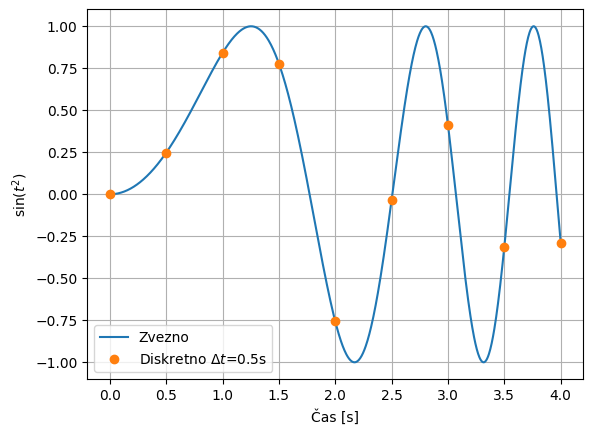

In [5]:
import numpy as np
import matplotlib.pyplot as plt


# na računalniku zvezne časovne vrste dejansko ne moremo generirati
# "zvezna" bo samo dosti bolj gosta
t, dt = np.linspace(0,4,1000, retstep=True)
t2, dt2 = np.linspace(0,4,9, retstep=True)

plt.plot(t, np.sin(t**2), label='Zvezno') 
plt.plot(t2, np.sin(t2**2), 'o',label='Diskretno $\\Delta t$=0.5s')
plt.xlabel('Čas [s]')
plt.ylabel('$\\sin(t^2)$')
plt.grid()
plt.legend()
plt.show()

(sec:klasifikacija_pod)=
## Klasifikacija procesov

Za poznejšo obravnavo bo pomembna klasifikacija procesov (prirejeno po {cite:t}`bendat_2011,shin2008`) kakor jo prikazuje spodnja slika.

![klasifikacija_procesov](./images/klasifikacija_procesov.svg)

Procese delimo na:
* **deterministične** (kdaj slišimo tudi *določljivostne*) to so procesi, ki imajo vrednosti (merjenih) signalov v času enolično določene in
* **naključne** kjer vrednosti (merjenih) signalov v nekem trenutku ekzaktno ne vemo, je pa ta lahko določena z verjetnostno porazdelitvijo.

Primer determinističnih procesov je funkcija:

$$
x(t) = \sin(t),
$$

primer naključnih procesov pa je meritev višine gladine razburkanega morja. Pri klasifikaciji podatkov ne smemo pozabiti, da imamo lahko procese sestavljene iz determinističnega in naključnega dela (npr. meritev profila izdelka vključuje tudi naključno merilno napako).

**Deterministične** procese naprej delimo na **periodične**, ki se torej po *določenemu času* (periodi) ponovijo in take, ki to niso, torej **neperiodične**. Periodične delimo na *harmonske*, ki jih definira sinusoida poljubne fazne zakasnitve in *kompleksno harmonske*, katere definira vsota več harmonskih komponent. Pri kompleksno harmonskih procesih je pomembno, da je razmerje frekvenc harmonskih komponent racionalno število, saj se bo v tem primeru perioda ponavljala s periodo najmanjše skupne periode. Če razmerje harmonskih komponent ni racionalno število, govorimo o *skoraj periodičnih* procesih, kateri pa spadajo v skupino neperiodičnih procesov. V skupino neperiodičnih procesov spadajo še rezultati *prehodnih* in *kaotičnih* procesov.

Razumevanje periodičnosti procesov ter vpliva neperiodičnosti na Fourierove vrste ({ref}`sec:fourierove_vrste`) in Fourierovo transformacijo ({ref}`sec:fourierova_int_transf`) je ključnega pomena za pravilno interpretacijo v frekvenčni domeni. 

**Naključne** procese naprej delimo glede na to, ali se statistična porazdelitev, ki definira naključne procese, s časom spreminja (**nestacionarni**) ali se ne spreminja (**stacionarni**); bolj podrobno bomo te in druge termin spoznali in tudi matematično podprli v poglavju: {ref}`sec:momenti_funkcije_gostote_verjetnosti`.

### Nekateri primeri determinističnih procesov

Spodja slika prikazuje periodične procese, najprej je prikazan trikotni signal, ki se ponavlja s periodo 1s, nato je prikazan harmonski signal, ki se prav tako ponavlja s periodo 1s.

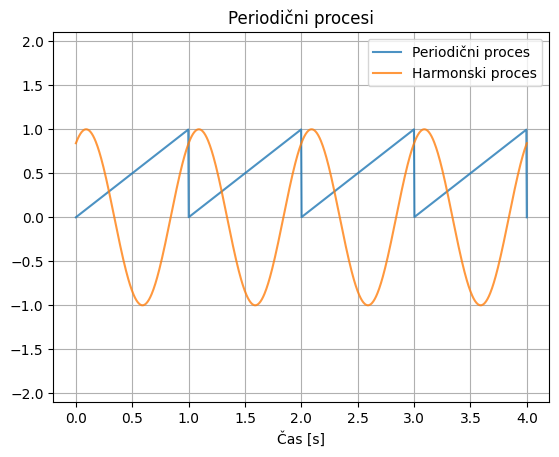

In [15]:
import numpy as np
import matplotlib.pyplot as plt


t, dt = np.linspace(0,4,1000, retstep=True)

plt.title('Periodični procesi')
plt.plot(t, t%1, label='Periodični proces', alpha=0.8) 
plt.plot(t, np.sin(2*np.pi*t+1), label='Harmonski proces', alpha=0.8) 
plt.ylim(-2.1,2.1)
plt.xlabel('Čas [s]')
plt.grid()
plt.legend()
plt.show()

Zadnji signal predstavlja kompleksno periodični proces, ki so sestavljeni kot vsota več harmonskih komponent, perioda tega na sliki je 2s.

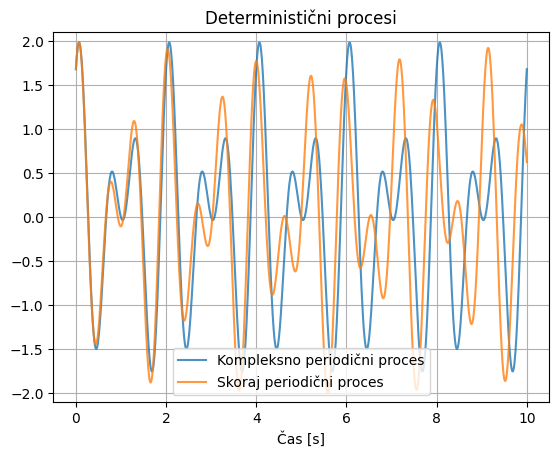

In [16]:
import numpy as np
import matplotlib.pyplot as plt


t, dt = np.linspace(0,10,1000, retstep=True)

plt.title('Deterministični procesi')
plt.plot(t, np.sin(2*np.pi*t+1)+np.sin(3*np.pi*t+1), label='Kompleksno periodični proces', alpha=0.8)
plt.plot(t, np.sin(2*np.pi*t+1)+np.sin(3.075*np.pi*t+1), label='Skoraj periodični proces', alpha=0.8)
plt.ylim(-2.1,2.1)
plt.xlabel('Čas [s]')
plt.grid()
plt.legend(loc=8)
plt.show()

Pri neperiodičnih procesih bomo kot primer prikazali prehodni proces, ki nastane, ko dinamski sistem vzbudimo z impulzno motnjo.

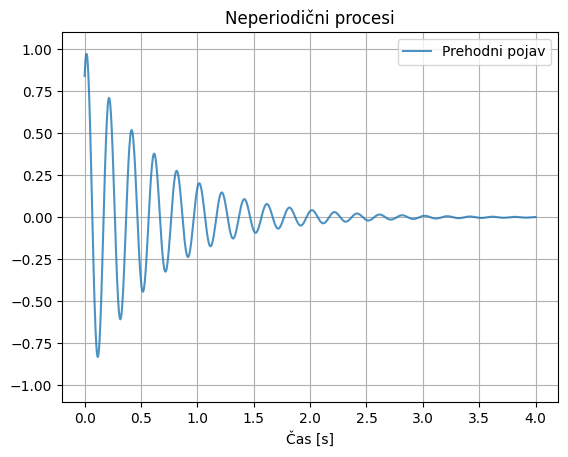

In [17]:
import numpy as np
import matplotlib.pyplot as plt


t, dt = np.linspace(0,4,1000, retstep=True)
omega = 10*np.pi
dušenje = 0.05

plt.title('Neperiodični procesi')

plt.plot(t, np.exp(-omega*dušenje*t)*np.sin(omega*t+1), label='Prehodni pojav', alpha=0.8) 
plt.ylim(-1.1,1.1)
plt.xlabel('Čas [s]')
plt.grid()
plt.legend()
plt.show()

Kaotičnih neperiodičnih procesov tukaj ne bomo podrobneje obravnavali; zanje velja, da jih zaradi visoke stopnje dinamičnosti lahko zanesljivo napovedujemo samo za relativno kratek čas v naprej, potem pa se njihovo obnašanje zdi čedalje bolj naključno.

Pri vzbujanju dinamskih sistemov pogosto uporabimo frekvenčni prelet (ali tudi žvižg); spodaj je prikazan 4s dolg linearni (frekvenca monotono narašča) žvižg od 1Hz do 5Hz.

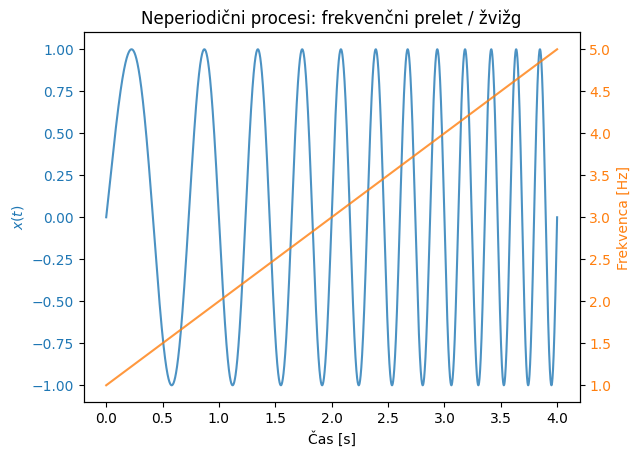

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pyExSi as es

fs = 44000
T = 4
t = np.linspace(0,T,fs*T+1)
x, _, fr = es.sine_sweep(time=t, freq_start=1, freq_stop=5, mode='linear', freq_return=True)

fig, ax1 = plt.subplots()
plt.title('Neperiodični procesi: frekvenčni prelet / žvižg')

ax1.set_xlabel('Čas [s]')
ax1.set_ylabel('$x(t)$', color='C0')
ax1.plot(t, x, color='C0', alpha=0.8)
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx() 
ax2.set_ylabel('Frekvenca [Hz]', color='C1')
ax2.plot(t, fr, color='C1', alpha=0.8) 
ax2.tick_params(axis='y', labelcolor='C1')
plt.show()

Pri analizi signalov nam občasno pomaga, da jih slišimo; spodaj lahko slišimo 4s dolg logaritemski žvižg od 100Hz do 16000Hz.

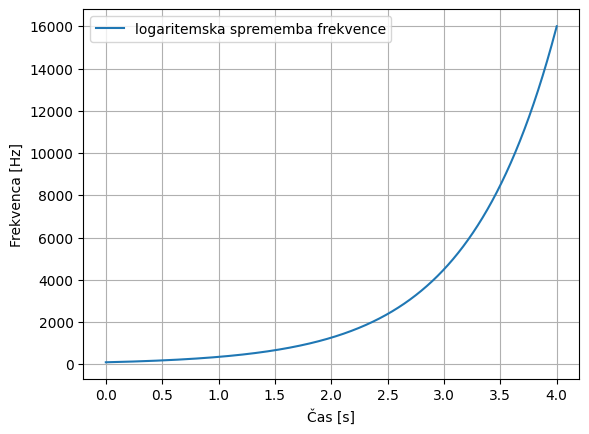

In [19]:
import numpy as np
import pyExSi as es
from IPython.display import Audio, display

fs = 44000
T = 4
t = np.linspace(0,T,fs*T+1)
x, _, fr = es.sine_sweep(time=t, freq_start=100, freq_stop=16000, mode='logarithmic', freq_return=True)
display(Audio(data=x, rate=fs))

plt.plot(t, fr, label='logaritemska sprememba frekvence')
plt.xlabel('Čas [s]')
plt.ylabel('Frekvenca [Hz]')
plt.grid()
plt.legend()
plt.show()

### Nekateri primeri naključnih procesov

Spodja slika prikazuje naključen proces z enakomerno porazdelitvijo. Na levi sliki je prikazanih prvih 50ms podatkov v času, desna slika pa prikazuje gostoto močnostnega spektra (glejte: {ref}`sec:PSD`). Opazimo lahko, da ima enakomerna porazdelitev tudi v frekvenčni domeni relativno konstano moč čez celotno analizirano frekvenčno področje (podatki so generirani s frekvenco vzorčenja 44kHz).

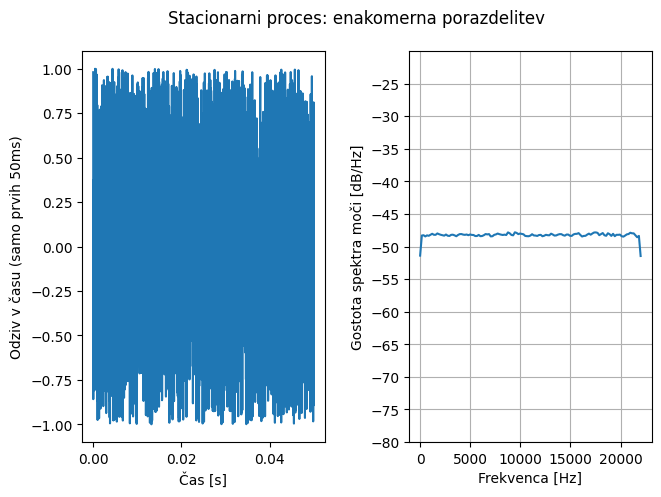

In [20]:
import numpy as np
import pyExSi as es
from IPython.display import Audio, display

fs = 44000
T = 4
t = np.linspace(0,T,fs*T+1)
N = len(t)
x = es.uniform_random(N=N)
sel = t<0.05
display(Audio(data=x, rate=fs))


fig, axs = plt.subplots(1,2)
fig.suptitle('Stacionarni proces: enakomerna porazdelitev')
plt.tight_layout(pad=1, w_pad=3)
axs[0].plot(t[sel], x[sel])
axs[0].set_xlabel('Čas [s]')
axs[0].set_ylabel('Odziv v času (samo prvih 50ms)')
axs[1].psd(x, Fs=fs)
axs[1].set_xlabel('Frekvenca [Hz]')
axs[1].set_ylabel('Gostota spektra moči [dB/Hz]')
axs[1].set_ylim(-80, -20)
axs[1].set_yticks(np.arange(-80,-20,5))
plt.show()

Ker je energija porazdejena čez (pre)široko frekvenčno področje, je vzbujanje dinamskih sistemov z enakomerno porazdelitvijo redko primerno. Ponavadi uporabimo normalno (ali tudi Gaussovo) porazdelitev z definiranim frekvenčnim spektrom. Spodnja slika prikazuje normalno porazdelitev z enakomerno gostoto moči v frekvenčnem področju od 1000Hz do 4000Hz. 

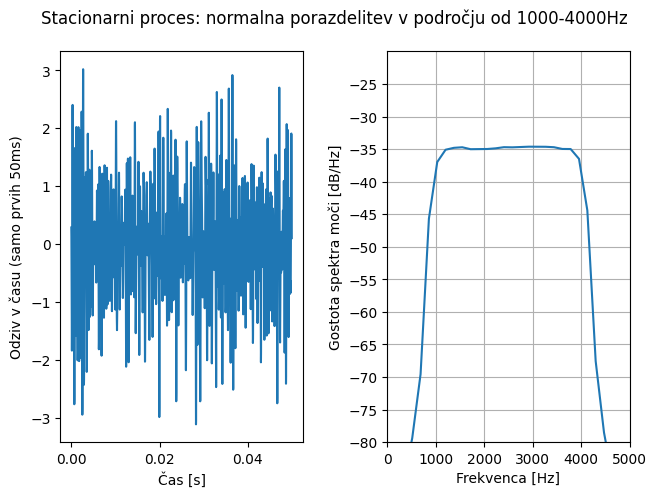

In [21]:
import numpy as np
import pyExSi as es
from IPython.display import Audio, display

fs = 44000
T = 4
t = np.linspace(0,T,fs*T+1)
N = len(t)

M = N // 2 + 1 # number of data points of frequency vector
freq = np.arange(0, M, 1) * fs / N # frequency vector
freq_lower = 1000 # PSD lower frequency limit  [Hz]
freq_upper = 4000 # PSD upper frequency limit [Hz]

PSD = es.get_psd(freq, freq_lower, freq_upper) # one-sided flat-shaped PSD
x = es.random_gaussian(N, PSD, fs)

sel = t<0.05
display(Audio(data=x, rate=fs))


fig, axs = plt.subplots(1,2)
fig.suptitle(f'Stacionarni proces: normalna porazdelitev v področju od {freq_lower}-{freq_upper}Hz')
plt.tight_layout(pad=1, w_pad=3)
axs[0].plot(t[sel], x[sel])
axs[0].set_xlabel('Čas [s]')
axs[0].set_ylabel('Odziv v času (samo prvih 50ms)')
axs[1].psd(x, Fs=fs)
axs[1].set_xlabel('Frekvenca [Hz]')
axs[1].set_ylabel('Gostota spektra moči [dB/Hz]')
axs[1].set_xlim(0, 5000)
axs[1].set_ylim(-80, -20)
axs[1].set_yticks(np.arange(-80,-20,5))
plt.show()

Za primerjavo si poglejmo še normalno porazdelitev z enakomerno gostoto moči v frekvenčnem področju od 100Hz do 400Hz. 

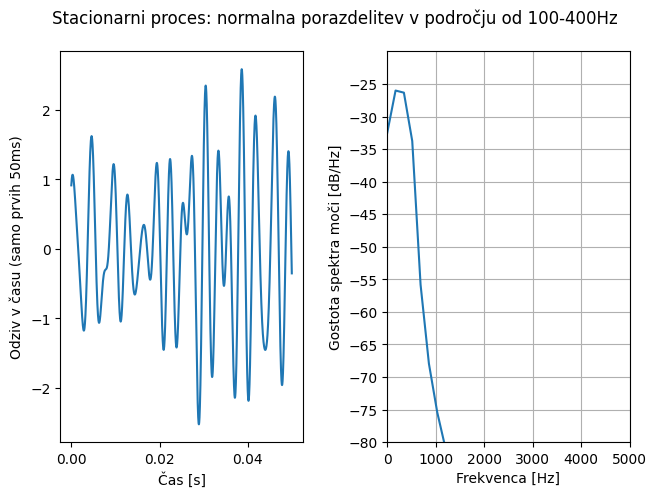

In [22]:
import numpy as np
import pyExSi as es
from IPython.display import Audio, display

fs = 44000
T = 4
t = np.linspace(0,T,fs*T+1)
N = len(t)

M = N // 2 + 1 # number of data points of frequency vector
freq = np.arange(0, M, 1) * fs / N # frequency vector
freq_lower = 100 # PSD lower frequency limit  [Hz]
freq_upper = 400 # PSD upper frequency limit [Hz]

PSD = es.get_psd(freq, freq_lower, freq_upper) # one-sided flat-shaped PSD
x = es.random_gaussian(N, PSD, fs)

sel = t<0.05
display(Audio(data=x, rate=fs))


fig, axs = plt.subplots(1,2)
fig.suptitle(f'Stacionarni proces: normalna porazdelitev v področju od {freq_lower}-{freq_upper}Hz')
plt.tight_layout(pad=1, w_pad=3)
axs[0].plot(t[sel], x[sel], label='Enakomerna porazdelitev')
axs[0].set_xlabel('Čas [s]')
axs[0].set_ylabel('Odziv v času (samo prvih 50ms)')
axs[1].psd(x, Fs=fs)
axs[1].set_xlabel('Frekvenca [Hz]')
axs[1].set_ylabel('Gostota spektra moči [dB/Hz]')
axs[1].set_xlim(0, 5000)
axs[1].set_ylim(-80, -20)
axs[1].set_yticks(np.arange(-80,-20,5))
plt.show()

Poglejmo si še nestacionarni proces. Začnemo s pripravo stacionarnega procesa enakomerne gostote moči v frekvenčnem področju od 1000Hz do 4000Hz in nenormalno porazdelitvijo (s parametrom sploščenosti=5, ang. *kurtosis*). Stacionarni proces nato moduliramo z nosilnim signalom v frekvenčnem področju od 10Hz do 20Hz, da dobimo nestacionarni proces. Kljub temu, da je gostota moči podobno porazdeljena kakor zgoraj, se nenormalni in nestacionarni proces ponavadi sliši bistveno bolj neprijetno; v primeru vibracijskega utrujanja je nestacionarno obremenjevanje ponavadi tudi bistveno bolj škodljivo.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pyExSi as es
from IPython.display import Audio, display

fs = 44000
T = 4
t = np.linspace(0,T,fs*T+1)
N = len(t)

M = N // 2 + 1 # number of data points of frequency vector
freq = np.arange(0, M, 1) * fs / N # frequency vector
freq_lower = 1000 # PSD lower frequency limit  [Hz]
freq_upper = 4000 # PSD upper frequency limit [Hz]
freq_lower_mod = 10 # modulating signals's PSD lower frequency limit  [Hz]
freq_upper_mod = 20 # modulating signals's PSD upper frequency limit [Hz]

PSD = es.get_psd(freq, freq_lower, freq_upper) # one-sided flat-shaped PSD
PSD_modulating = es.get_psd(freq, freq_lower_mod, freq_upper_mod) # one-sided flat-shaped PSD

k_u = 5
x = es.nonstationary_signal(N,PSD,k_u=k_u, fs=fs, modulating_signal=('PSD',PSD_modulating))

sel = t<0.25
display(Audio(data=x, rate=fs))


fig, axs = plt.subplots(1,2)
fig.suptitle(f'Nestacionarni proces: nenormalna porazdelitev v področju od {freq_lower}-{freq_upper}Hz')
plt.tight_layout(pad=1, w_pad=3)
axs[0].plot(t[sel], x[sel])
axs[0].set_xlabel('Čas [s]')
axs[0].set_ylabel(f'Odziv v času (samo prvih 250ms)')
axs[1].psd(x, Fs=fs)
axs[1].set_xlabel('Frekvenca [Hz]')
axs[1].set_ylabel('Gostota spektra moči [dB/Hz]')
axs[1].set_xlim(0, 5000)
axs[1].set_ylim(-80, -20)
axs[1].set_yticks(np.arange(-80,-20,5))
plt.show()